In [ ]:
# [★중요★] 이 셀을 노트북 가장 처음에 실행하세요!
!pip install tensorflow==2.13.0

# ----------------------------------------------------
# [!] 실행 후, Colab 런타임이 자동으로 재시작되거나
#     "RESTART RUNTIME" 버튼을 눌러 수동으로 재시작해야 합니다.
# ----------------------------------------------------

ERROR: Could not find a version that satisfies the requirement tensorflow==2.13.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.13.0


In [ ]:
import tensorflow as tf
print(tf.__version__)
# 출력 결과가 '2.13.0'으로 나와야 합니다.

2.19.0


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from google.colab import drive
import os
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('drive/MyDrive/식물을 부탁해/')

Mounted at /content/drive


In [ ]:

DATASET_DIR = "/content/drive/MyDrive/식물을 부탁해/seungwoo/wild_cropped_images"

TRAIN_DIR = os.path.join(DATASET_DIR, 'train')
VAL_DIR = os.path.join(DATASET_DIR, 'validation')

IMG_SIZE = 299
BATCH_SIZE = 32
NUM_CLASSES = 15 # 식물 15종
EPOCHS_PHASE_1 = 15 # 1단계 학습 (헤드만)
EPOCHS_PHASE_2 = 15 # 2단계 학습 (미세조정)

In [ ]:

import os

count = sum([len(files) for r, d, files in os.walk(TRAIN_DIR)])

print(f"📂 지정된 경로: {TRAIN_DIR}")
print(f"🔢 발견된 학습 이미지 개수: {count}장")



📂 지정된 경로: /content/drive/MyDrive/식물을 부탁해/seungwoo/wild_cropped_images/train
🔢 발견된 학습 이미지 개수: 6933장

✅ [성공] 데이터가 충분합니다. (기존 데이터 + 야생 데이터)
   학습을 진행합니다! 🚀


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),        # 랜덤으로 좌우 반전
    layers.RandomRotation(0.2),           # -20% ~ +20% 범위에서 랜덤 회전
    layers.RandomZoom(0.2),               # 20% 범위 내에서 랜덤 확대/축소
    layers.RandomContrast(0.2),           # 20% 범위 내에서 랜덤 대비 변경
    # layers.RandomBrightness(0.2)        # 랜덤 밝기 조절 (필요시 주석 해제)
], name="data_augmentation")

# --- 3-B. 데이터 로드 (이전 3번 셀과 동일) ---

# 1. 학습(Train) 데이터셋 로더
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=True
)

# 2. 검증(Validation) 데이터셋 로더
val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=False # 검증 데이터는 절대 섞거나 증강하지 않음
)

# 3. 클래스 이름 확인
class_names = train_ds.class_names
print("클래스 이름 (폴더명 순서):", class_names)
print(f"총 {len(class_names)}개의 클래스")

# 4. MobileNet 전용 전처리 함수 (픽셀 스케일링)
def preprocess_layer(image, label):
    return preprocess_input(image), label

# 데이터 파이프라인 재구성 ---

# 학습(Train) 데이터셋: (이미지, 라벨) -> (증강된 이미지, 라벨) -> (전처리된 이미지, 라벨)
train_ds = train_ds.map(
    lambda image, label: (data_augmentation(image, training=True), label)
).map(preprocess_layer).prefetch(buffer_size=tf.data.AUTOTUNE)

# 검증(Validation) 데이터셋: (증강 없음) -> (전처리된 이미지, 라벨)
val_ds = val_ds.map(preprocess_layer).prefetch(buffer_size=tf.data.AUTOTUNE)


Found 6933 files belonging to 15 classes.
Found 1706 files belonging to 15 classes.
클래스 이름 (폴더명 순서): ['관음죽', '금전수', '디펜바키아', '몬스테라', '벵갈고무나무', '보스턴고사리', '부레옥잠', '선인장', '스투키', '스파티필럼', '오렌지쟈스민', '올리브나무', '테이블야자', '호접란', '홍콩야자']
총 15개의 클래스를 찾았습니다.
✅ 데이터 증강(Augmentation)이 포함된 파이프라인이 준비되었습니다.


In [ ]:
# 1. 베이스 모델(MobileNetV2) 로드 (ImageNet 가중치 사용)
# include_top=False : ImageNet 1000개 분류기 부분은 "제외"
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# 2. 베이스 모델의 가중치를 "동결" (학습되지 않도록)
# -> 1단계에서는 이 똑똑한 모델을 망가뜨리지 않기 위함
base_model.trainable = False

# 3. 새로운 분류기 "헤드" 구축 (이 부분만 학습시킬 것)
inputs = base_model.input
x = base_model.output
x = layers.GlobalAveragePooling2D()(x) # (배치, 7, 7, 1280) -> (배치, 1280)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x) # 15개 클래스 출력

# 4. 베이스 모델과 새 헤드 연결
model = Model(inputs=inputs, outputs=outputs)

# 5. 모델 컴파일
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', # label_mode='int'이므로 'sparse_' 사용
    metrics=['accuracy']
)

# 모델 구조 요약
model.summary()

/tmp/ipython-input-1108403092.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 150, 150,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 150, 150,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 150, 150,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 150, 150,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 150, 150,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 150, 150,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 150, 150,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 150, 150,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 150, 150,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 150, 150,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 150, 150,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 151, 151,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 75, 75,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 75, 75,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 75, 75,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 75, 75,    │      2,304 │ block_1_depthwis

 Total params: 2,423,887 (9.25 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
print("--- 1단계 학습 (헤드만) 시작 ---")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_PHASE_1
)
print("--- 1단계 학습 완료 ---")

--- 1단계 학습 (헤드만) 시작 ---
Epoch 1/15
217/217 ━━━━━━━━━━━━━━━━━━━━ 753s 3s/step - accuracy: 0.5355 - loss: 1.5464 - val_accuracy: 0.9209 - val_loss: 0.3081
Epoch 2/15
217/217 ━━━━━━━━━━━━━━━━━━━━ 158s 728ms/step - accuracy: 0.8719 - loss: 0.4421 - val_accuracy: 0.9467 - val_loss: 0.1974
Epoch 3/15
217/217 ━━━━━━━━━━━━━━━━━━━━ 156s 719ms/step - accuracy: 0.9020 - loss: 0.3228 - val_accuracy: 0.9572 - val_loss: 0.1443
Epoch 4/15
217/217 ━━━━━━━━━━━━━━━━━━━━ 156s 717ms/step - accuracy: 0.9163 - loss: 0.2747 - val_accuracy: 0.9707 - val_loss: 0.1224
Epoch 5/15
217/217 ━━━━━━━━━━━━━━━━━━━━ 156s 719ms/step - accuracy: 0.9278 - loss: 0.2360 - val_accuracy: 0.9654 - val_loss: 0.1146
Epoch 6/15
217/217 ━━━━━━━━━━━━━━━━━━━━ 157s 724ms/step - accuracy: 0.9322 - loss: 0.2195 - val_accuracy: 0.9754 - val_loss: 0.0950
Epoch 7/15
217/217 ━━━━━━━━━━━━━━━━━━━━ 157s 724ms/step - accuracy: 0.9319 - loss: 0.2082 - val_accuracy: 0.9783 - val_loss: 0.0758
Epoch 8/15
217/217 ━━━━━━━━━━━━━━━━━━━━ 157s 720ms/step

In [ ]:
print("--- 2단계 학습 (미세조정) 시작 ---")

# 1. 베이스 모델 동결 해제
base_model.trainable = True

# 2. 상위 레이어만 학습되도록 설정 (예: 상위 50개 레이어
# MobileNetV2는 총 154개 레이어
fine_tune_at = 100 # 100번째 레이어부터는 동결 해제 (학습 O)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False # 하위 100개 레이어는 여전히 동결 (학습 X)

# 3. (매우 중요) 아주 낮은 학습률로 다시 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # 0.00001
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 4. 2단계 학습(미세조정) 실행
# 1단계에서 10 epochs 돌렸으므로, 이어서 10~20까지 돌림
total_epochs = EPOCHS_PHASE_1 + EPOCHS_PHASE_2

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] # 이전 학습에 이어서
)

print("---  모든 학습 완료  ---")

--- 2단계 학습 (미세조정) 시작 ---
Epoch 15/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 194s 789ms/step - accuracy: 0.7769 - loss: 0.8182 - val_accuracy: 0.9789 - val_loss: 0.0711
Epoch 16/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 156s 717ms/step - accuracy: 0.9245 - loss: 0.2437 - val_accuracy: 0.9795 - val_loss: 0.0677
Epoch 17/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 155s 712ms/step - accuracy: 0.9383 - loss: 0.1991 - val_accuracy: 0.9812 - val_loss: 0.0610
Epoch 18/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 156s 719ms/step - accuracy: 0.9478 - loss: 0.1664 - val_accuracy: 0.9824 - val_loss: 0.0596
Epoch 19/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 154s 707ms/step - accuracy: 0.9518 - loss: 0.1460 - val_accuracy: 0.9848 - val_loss: 0.0526
Epoch 20/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 155s 711ms/step - accuracy: 0.9582 - loss: 0.1247 - val_accuracy: 0.9853 - val_loss: 0.0485
Epoch 21/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 157s 723ms/step - accuracy: 0.9692 - loss: 0.0955 - val_accuracy: 0.9853 - val_loss: 0.0444
Epoch 22/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 154

In [ ]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


IMG_SIZE = 299 # 학습 시 사용된 크기를 명시

# 새로 저장할 SavedModel 폴더 경로 (폴더로 저장되므로 확장자가 없음)
SAVEDMODEL_PATH_SIG = os.path.join(DATASET_DIR, "mobilenet_plant_classifier_final_v2")

# ----------------------------------------------------
# 2. 시그니처 정의 및 저장
# ----------------------------------------------------

print(f"1. SavedModel 시그니처 정의 시작...")

# --- 입력 텐서 이름 확인 ---
input_name = 'input_1'
try:
    # 학습된 모델의 실제 입력 텐서 이름 추출
    input_tensor = model.inputs[0]
    input_name = input_tensor.name.split(':')[0]
    print(f" 모델의 입력 텐서 이름 확인: **'{input_name}'**")
except Exception:
    print(f" 모델 입력 이름 추출 실패. 기본값 '{input_name}'을 사용합니다.")


#   serving_default 시그니처를 위한 tf.function 정의
@tf.function(input_signature=[
    tf.TensorSpec(
        # 299x299 크기 명시
        shape=[None, IMG_SIZE, IMG_SIZE, 3],
        dtype=tf.float32,
        name=input_name
    )
])
def serving_fn(input_tensor):
    # Keras 모델의 추론을 호출하고, 출력 포맷을 딕셔너리로 맞춥니다.
    return {'output_0': model(input_tensor)}


print(f"\n2. SavedModel 포맷으로 저장 시작 (시그니처 포함): {SAVEDMODEL_PATH_SIG}")

#  Model.export()를 사용하여 시그니처를 명시적으로 전달하여 저장
model.export(
    SAVEDMODEL_PATH_SIG,
    signatures={'serving_default': serving_fn} # signatures 명시
)

print("\n---  최종 SavedModel 저장 완료  ---")
print(f" SavedModel 폴더: **{SAVEDMODEL_PATH_SIG}**")

1. SavedModel 시그니처 정의 시작...
✅ 모델의 입력 텐서 이름 확인: **'keras_tensor_5'**

2. SavedModel 포맷으로 저장 시작 (시그니처 포함): /content/drive/MyDrive/식물을 부탁해/seungwoo/wild_cropped_images/mobilenet_plant_classifier_final_v2
Saved artifact at '/content/drive/MyDrive/식물을 부탁해/seungwoo/wild_cropped_images/mobilenet_plant_classifier_final_v2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='keras_tensor_5')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  135297766869520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135297711043024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135297711043216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135297711042448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135297711041872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135297711042640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13529771104

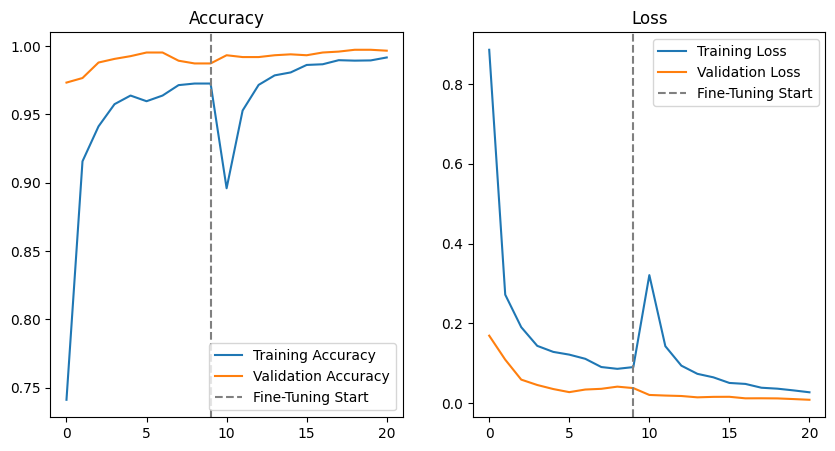

In [ ]:
# 1단계 + 2단계 학습 기록 합치기
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

# 정확도 그래프
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(x=EPOCHS_PHASE_1 - 1, color='grey', linestyle='--', label='Fine-Tuning Start')
plt.title('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=EPOCHS_PHASE_1 - 1, color='grey', linestyle='--', label='Fine-Tuning Start')
plt.title('Loss')
plt.legend()

plt.show()

In [ ]:
!pip show tensorflow


Name: tensorflow
Version: 2.19.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tensorflow_decision_forests, tf_keras
